# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

Note: This notebook is run on kaggle server.

# Table of Contents

    1. Load Data and artificial dataset construction
       1.1 Load data
       1.2 IR inspection
       1.3 Artificial dataset Construction
    2. Data clean and EDA
       2.1 Numerical feature clean and EDA
    3. Splitting data and Feature Engineering
       3.1 Split data
       3.2 Feature engineer
           3.2.1 Standardise numerical variables
    4. Obtain resampling data
    5. Model training
       5.1 Random forest
       5.2 Neural network
       5.3 Logit
           5.3.1 Logit training
           5.3.2 Apply resampling methods on Logit
       5.4 XGBoost
           5.4.1 XGBoost training
           5.4.2 Apply resampling methods on XGBoost
    6. XAI
       6.1 SHAP fearure importance
           6.1.1 Calculate SHAP feature importance
           6.1.2 SHAP rank correlation
           6.1.3 SHAP feature importance visualisation
       6.2 PFI
           6.2.1 Calculate PFI
           6.2.2 PFI rank correlation
           6.2.3 PFI feature importance visualisation

In [1]:
# Inspecting dataport libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

%load_ext autoreload
%autoreload 2

# 1. Load Data and artificial dataset construction

## 1.1 Load data

In [ ]:
gmc_ori = pd.read_csv("/kaggle/input/GiveMeSomeCredit/cs-training.csv", sep=",")
gmc_ori = gmc_ori.drop(columns=['Unnamed: 0'])

#change column names
gmc_ori.rename(columns={'SeriousDlqin2yrs': 'target',
                        'RevolvingUtilizationOfUnsecuredLines': 'RU',
                        'NumberOfTime30-59DaysPastDueNotWorse':'NPD30',
                        'NumberOfOpenCreditLinesAndLoans':'NL_car',
                        'NumberOfTimes90DaysLate':'NPD90',
                        'NumberRealEstateLoansOrLines':'NL_estate',
                        'NumberOfTime60-89DaysPastDueNotWorse':'NPD60',
                        'NumberOfDependents':'ND'},
                inplace=True)

print(gmc_ori.shape)
print(gmc_ori.info())

## 1.2 IR inspection

In [ ]:
gmc_ori.target.value_counts()

In [ ]:
IR_ori = round(len(gmc_ori.loc[gmc_ori['target'] == 0])/len(gmc_ori.loc[gmc_ori['target'] == 1]),2)
print('The imbalance ratio of the original data set is '+ str(IR_ori))

In [ ]:
gmc_ori.target.value_counts().plot.pie(autopct = "%.2f")

## 1.3 Artificial dataset Construction

In [ ]:
minority = gmc_ori[gmc_ori['target']==1]
majority = gmc_ori[gmc_ori['target']==0]

In [ ]:
np.random.seed(10)
remove_n = int(minority.shape[0] - majority.shape[0]/20)
drop_indices = np.random.choice(minority.index, remove_n, replace=False)
minority_art = minority.drop(drop_indices)
print(minority_art.shape) 

In [ ]:
gmc = pd.concat([majority, minority_art])
IR_art = round(len(gmc.loc[gmc['target'] == 0])/len(gmc.loc[gmc['target'] == 1]),2)

print(gmc.shape)
print(gmc.target.value_counts())
print('The imbalance ratio of artificial data set is '+ str(IR_art))

# 2. Data clean and EDA

## 2.1 Numerical feature clean and EDA

In [ ]:
#numerical variables 
numvars = ['RU', 'age', 
           'NPD30', 'DebtRatio', 'MonthlyIncome', 
           'NL_car', 'NPD90', 'NL_estate','NPD60','ND']
gmc[numvars].info()

### Check the missing values

In [ ]:
print(gmc[numvars].isnull().sum() )

In [ ]:
for col in numvars:  # loop over all numeric columns which missing value under 20%
    if gmc[col].isna().sum() > 0:                        
        m = gmc[col].median(skipna=True)                  
        gmc[col].fillna(m, inplace=True)                 

In [ ]:
# check the missing values
print(gmc[numvars].isnull().sum() )

### EDA

In [ ]:
#check the distribution
plt.rcParams["figure.figsize"] = (20,10)
num_vars = gmc[numvars]
num_vars.plot(kind = 'box', subplots=True);

In [ ]:
# check the distribution
gmc[numvars].hist(bins=20);

### Check the correlation

In [ ]:
all_num = ['RU', 'age', 
           'NPD30', 'DebtRatio', 'MonthlyIncome', 
           'NL_car', 'NPD90', 'NL_estate','NPD60','ND', 'target']

In [ ]:
sns.heatmap(gmc[all_num].corr(),annot=True,linewidth=.5,fmt='1f')
plt.title('Correlation Matrix plot of numerical data')
plt.show()

# 3. Splitting data and Feature Engineering

## 3.1 Splitting data

In [ ]:
y = gmc['target']
X = gmc.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2,shuffle=True, random_state= 1)

## 3.2 Feature engineer

### 3.2.1 Standardise numerical variables

In [ ]:
standard = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numvars] = standard.fit_transform(X_train_scaled[numvars])
X_val_scaled[numvars] = standard.transform(X_val_scaled[numvars])

X_val_scaled[numvars].head()

In [ ]:
X_train_final = X_train_scaled[numvars]
X_val_final = X_val_scaled[numvars]

# 4. Obtain resampling data

In [22]:
def resampling(ratio=1):
    X_data_list = []
    y_data_list = []
    for single_class in classes:
        if single_class == NearMiss:
            instance = single_class(sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))  
        else:
            instance = single_class(random_state=40, sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))       
    return X_data_list, y_data_list

In [23]:
classes = [RandomOverSampler, SMOTE, BorderlineSMOTE,
           RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
           SMOTEENN, SMOTETomek]

#IR=1
X_data_list1, y_data_list1 = resampling(1)

print(len(X_data_list1),len(y_data_list1))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 1 completed
Resampled dataset shape Counter({0: 7999, 1: 7999})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 1 completed
Resampled dataset shape Counter({0: 403, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 1 completed
Resampled dataset shape Counter({0: 403, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 1 completed
Resampled dataset shape Counter({0: 2025, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 1 completed
Resampled dataset shape Counter({1: 7719, 0: 5676})
<class 'i

In [24]:
#IR=5
X_data_list2, y_data_list2 = resampling(0.2)

print(len(X_data_list2),len(y_data_list2))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 7999, 1: 1599})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 2015, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.2 completed
Resampled dataset shape Counter({0: 2015, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.2 completed
Resampled dataset shape Counter({0: 2025, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.2 completed
Resampled dataset shape Counter({0: 6424, 1: 

In [25]:
#IR=10
X_data_list3, y_data_list3 = resampling(0.1)

print(len(X_data_list3),len(y_data_list3))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 7999, 1: 799})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 4030, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.1 completed
Resampled dataset shape Counter({0: 4030, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.1 completed
Resampled dataset shape Counter({0: 4601, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.1 completed
Resampled dataset shape Counter({0: 6801, 1: 238

In [26]:
#IR=15
X_data_list4, y_data_list4 = resampling(0.0667)

print(len(X_data_list4),len(y_data_list4))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 7999, 1: 533})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 6041, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.0667 completed
Resampled dataset shape Counter({0: 6041, 1: 403})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.0667 completed
Resampled dataset shape Counter({0: 6188, 1: 403})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.0667 completed
Resampled dataset shape Cou

# 5. Model training

## 5.1 Random forest

In [ ]:
#grid search for hyper parameter tuning

rf = RandomForestClassifier(random_state=0)                       

param_grid = {'n_estimators': [25, 50, 100],
              'max_features': [2, 4, 8]
              }

gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=0)
gs_rf.fit(X_train_final, y_train.values.ravel())     
rf_tune = gs_rf.best_estimator_
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
print(rf_tune)

In [ ]:
rf_tune=RandomForestClassifier(random_state=0, max_features = 2, n_estimators =100)
rf_tune.fit(X_train_final, y_train.values.ravel())

In [ ]:
def evaluation(y_tr,X_tr,y_va,X_va,model):
    return roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1]).round(3),\
           roc_auc_score(y_va, model.predict_proba(X_va)[:,1]).round(3),\
           metrics.precision_score(y_va, model.predict(X_va)).round(3),\
           metrics.recall_score(y_va, model.predict(X_va)).round(3),\
           geometric_mean_score(np.ravel(y_va), model.predict(X_va)).round(3),\
           f1_score(y_va, model.predict(X_va)).round(3),\
           metrics.confusion_matrix(y_va, model.predict(X_va))

In [ ]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,rf_tune)
rf_eva = ['RF', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
rf_eva

## 5.2  neural network

In [ ]:
# Define model
model = keras.Sequential([ 
    keras.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])

# Compile model
model.compile(optimizer = 'adam',
    loss="binary_crossentropy",
    metrics = ["AUC"]
)
print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [ ]:
# Fit the model
history = model.fit(X_train_final,
                    y_train,
                    epochs = 20,
                    batch_size = 128,
                    validation_data=(X_val_final, y_val),
                    callbacks=[early_stopping_monitor])

In [ ]:
def evaluation_nn(y_tr, X_tr, y_va,X_va, model):
    return roc_auc_score(y_tr, model.predict(X_tr)).round(3),\
           roc_auc_score(y_va, model.predict(X_va)).round(3),\
           metrics.precision_score(y_va, np.where(model.predict(X_va) >= 0.5, 1, 0)).round(3),\
           metrics.recall_score(y_va, np.where(model.predict(X_va) >= 0.5, 1, 0)).round(3),\
           geometric_mean_score(np.ravel(y_va), np.ravel(np.where(model.predict(X_va) >= 0.5, 1, 0))).round(3),\
           f1_score(y_va, np.where(model.predict(X_va) >= 0.5, 1, 0)).round(3),\
           metrics.confusion_matrix(y_va, np.where(model.predict(X_va) >= 0.5, 1, 0))

In [ ]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation_nn(y_train,X_train_final,y_val,X_val_final,model)
nn_eva = ['NN', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
nn_eva

## 5.3 Logit

In [ ]:
logit = LogisticRegressionCV(cv=5, random_state=0, max_iter=2000).fit(X_train_final,y_train.values.ravel())

In [ ]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,logit)
logit_eva = ['logit', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
logit_eva

### 5.3.2 Applying resampling methods on logit

In [ ]:
def logit_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_lr = logit.fit(X_data, y_data)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_lr)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
        #print evaluation lists
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog = pd.DataFrame(dic)
dflog.loc[len(dflog)] = logit_eva
dflog

In [ ]:
#IR = 5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog2 = pd.DataFrame(dic)
dflog2.loc[len(dflog2)] = logit_eva
dflog2

In [ ]:
#IR = 10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog3 = pd.DataFrame(dic)
dflog3.loc[len(dflog3)] = logit_eva
dflog3

In [ ]:
#IR = 15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog4 = pd.DataFrame(dic)
dflog4.loc[len(dflog4)] = logit_eva
dflog4

### Aggregate and output result

In [ ]:
#aggregate AUC validation
dflogit = pd.concat([dflog4.iloc[:,2],dflog3.iloc[:,2],dflog2.iloc[:,2],dflog.iloc[:,2]],axis=1)
dflogit.columns = ['1:15', '1:10', '1:5', '1:1']
dflogit.index = dflog4.iloc[:,0]
dflogit

In [ ]:
dflogit.to_csv('/kaggle/working/kaggle_logit_auc.csv', index =True, encoding = 'utf-8-sig') 

In [ ]:
#aggregate gmeans
logit_gmeans = pd.concat([dflog4.iloc[:,5],dflog3.iloc[:,5],dflog2.iloc[:,5],dflog.iloc[:,5]],axis=1)
logit_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
logit_gmeans.index = dflog4.iloc[:,0]
logit_gmeans

In [ ]:
logit_gmeans.to_csv('/kaggle/working/kaggle_logit_gmeans.csv', index =True, encoding = 'utf-8-sig') 

In [ ]:
#aggregate fmeasure
logit_fmeasure = pd.concat([dflog4.iloc[:,6],dflog3.iloc[:,6],dflog2.iloc[:,6],dflog.iloc[:,6]],axis=1)
logit_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
logit_fmeasure.index = dflog4.iloc[:,0]
logit_fmeasure

In [ ]:
logit_fmeasure.to_csv('/kaggle/working/kaggle_logit_fmeasure.csv', index =True, encoding = 'utf-8-sig') 

## XGBoost

In [ ]:
#perform hyper parameter grid search

xgb_param_grid = {
    'colsample_bytree': np.linspace(0.1, 0.8, 3), # Subsample ratio of columns when constructing each tree
    'n_estimators': [50,75,100],  # Number of gradient boosted trees
    'max_depth': [3, 5, 8],   # max depth of decision trees
    'learning_rate': np.linspace(0.01, 0.1, 3), #Boosting learning rate
    'subsample': np.linspace(0.5, 0.8, 3)}  # Subsample ratio of the training instance

gs_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric ='auc'), 
                      param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)

gs_xgb.fit(X_train_final, y_train.values.ravel())
xgb_tune = gs_xgb.best_estimator_

print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
print(xgb_tune)

In [ ]:
#run this to skip xgb tuning
xgb_tune = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
xgb_tune.fit(X_train_final, y_train.values.ravel())

In [ ]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,xgb_tune)
xgb_eva=['xgb', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
xgb_eva

### xgb + resampling approaches

In [ ]:
def xgb_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = xgb_tune.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_xgb)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
        #print evaluation lists
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
# IR=1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb = pd.DataFrame(dic)
dfxgb.loc[len(dfxgb)] = xgb_eva
dfxgb

In [ ]:
# IR=5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb2 = pd.DataFrame(dic)
dfxgb2.loc[len(dfxgb2)] = xgb_eva
dfxgb2

In [ ]:
#IR=10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb3 = pd.DataFrame(dic)
dfxgb3.loc[len(dfxgb3)] = xgb_eva
dfxgb3

In [ ]:
#IR=15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb4 = pd.DataFrame(dic)
dfxgb4.loc[len(dfxgb4)] = xgb_eva
dfxgb4

### Aggregate and output results

In [ ]:
#aggregate AUC validation
dfxgboost = pd.concat([dfxgb4.iloc[:,2],dfxgb3.iloc[:,2],dfxgb2.iloc[:,2],dfxgb.iloc[:,2]],axis=1)
dfxgboost.columns = ['1:15', '1:10', '1:5', '1:1']
dfxgboost.index = dfxgb4.iloc[:,0]
dfxgboost

In [ ]:
dfxgboost.to_csv('/kaggle/working/kaggle_xgb_auc.csv', index = True, encoding = 'utf-8-sig') 

In [ ]:
#aggregate gmeans
xgb_gmeans = pd.concat([dfxgb4.iloc[:,5],dfxgb3.iloc[:,5],dfxgb2.iloc[:,5],dfxgb.iloc[:,5]],axis=1)
xgb_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_gmeans.index = dfxgb4.iloc[:,0]
xgb_gmeans

In [ ]:
xgb_gmeans.to_csv('/kaggle/working/kaggle_xgb_gmeans.csv', index = True, encoding = 'utf-8-sig') 

In [ ]:
#aggregate fmeasure
xgb_fmeasure = pd.concat([dfxgb4.iloc[:,6],dfxgb3.iloc[:,6],dfxgb2.iloc[:,6],dfxgb.iloc[:,6]],axis=1)
xgb_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_fmeasure.index = dfxgb4.iloc[:,0]
xgb_fmeasure

In [ ]:
xgb_fmeasure.to_csv('/kaggle/working/kaggle_xgb_fmeasure.csv', index = True, encoding = 'utf-8-sig') 

In [ ]:
#aggregate the evaluation results for four models
models = [logit_eva[0], rf_eva[0],xgb_eva[0],nn_eva[0]]
AUC_val = [logit_eva[2], rf_eva[2],xgb_eva[2],nn_eva[2]]
Gmeans = [logit_eva[5], rf_eva[5],xgb_eva[5],nn_eva[5]]
Fmeasure = [logit_eva[6], rf_eva[6],xgb_eva[6],nn_eva[6]]
dic ={'Model': models, 'AUC_validation':AUC_val, 'G-means':Gmeans, 'F1-score':Fmeasure}
models_eva = pd.DataFrame(dic)
models_eva

In [ ]:
models_eva.to_csv('/kaggle/working/kaggle_models.csv', index = True, encoding = 'utf-8-sig') 

# 6. XAI

## 6.1 SHAP fearure importance

### 6.1.1 Calculate SHAP feature importance

In [116]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
explainer_xgb = shap.TreeExplainer(xgb_tune, data=X_train_final, 
                                   feature_perturbation='interventional', model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_train_final)
print(shap_values_xgb.shape)

result__ = pd.DataFrame(shap_values_xgb, columns = X_train_final.columns)

#for global importance, we average the absolute Shapley values per feature across the data: 
vals__ = np.abs(result__.values).mean(0).round(3)
shap_importance = pd.DataFrame(list(zip(X_train_final.columns, vals__)),
                                  columns=['feature','xgb'])
print(shap_importance.head())

 96%|=================== | 3828/4007 [00:17<00:00]       

[ 0.00158482  0.00106996  0.00024321 -0.0072286  -0.00231053 -0.01252233
  0.00329277 -0.00319203 -0.02978729 -0.00165364 -0.0014676 ]
(4007, 11)
   feature    xgb
0     LOAN  0.006
1  MORTDUE  0.005
2    VALUE  0.005
3      YOJ  0.006
4    DEROG  0.007


In [118]:
def shap_generator(X_data_list, y_data_list,model):
    vals_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,
                                 eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        explainer_instance = shap.TreeExplainer(model, data=X_data, 
                                                feature_perturbation='interventional', model_output='probability')
        shap_values_instance = explainer_instance.shap_values(X_data)
        result = pd.DataFrame(shap_values_instance, columns = X_data.columns)
        vals = np.abs(result.values).mean(0).round(3)
        
        vals_list.append(vals)
    return vals_list

In [117]:
#extract RUS,IHT resampled data sets
#order: rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
RE_Xlist= [X_data_list1[3],X_data_list2[3],X_data_list3[3], X_data_list4[3],
           X_data_list1[4],X_data_list2[4], X_data_list3[4], X_data_list4[4]]
RE_ylist =[y_data_list1[3],y_data_list2[3],y_data_list3[3], y_data_list4[3],
           y_data_list1[4],y_data_list2[4], y_data_list3[4], y_data_list4[4]]

In [119]:
shap_list = shap_generator(RE_Xlist, RE_ylist,xgb_tune)

[0]	validation_0-auc:0.64009
[1]	validation_0-auc:0.74397
[2]	validation_0-auc:0.70748
[3]	validation_0-auc:0.71456
[4]	validation_0-auc:0.72308
[5]	validation_0-auc:0.79952
[6]	validation_0-auc:0.83417
[7]	validation_0-auc:0.83475
[8]	validation_0-auc:0.82105
[9]	validation_0-auc:0.82810
[10]	validation_0-auc:0.84115
[11]	validation_0-auc:0.84510
[12]	validation_0-auc:0.83480
[13]	validation_0-auc:0.84049
[14]	validation_0-auc:0.84676
[15]	validation_0-auc:0.85173
[16]	validation_0-auc:0.85219
[17]	validation_0-auc:0.86140
[18]	validation_0-auc:0.87107
[19]	validation_0-auc:0.87219
[20]	validation_0-auc:0.87508
[21]	validation_0-auc:0.87401
[22]	validation_0-auc:0.87183
[23]	validation_0-auc:0.87488
[24]	validation_0-auc:0.87762
[25]	validation_0-auc:0.88023
[26]	validation_0-auc:0.88325
[27]	validation_0-auc:0.87919
[28]	validation_0-auc:0.88140
[29]	validation_0-auc:0.88379
[30]	validation_0-auc:0.88437
[31]	validation_0-auc:0.88305
[32]	validation_0-auc:0.88247
[33]	validation_0-au

[75]	validation_0-auc:0.91787
[76]	validation_0-auc:0.91830
[77]	validation_0-auc:0.91754
[78]	validation_0-auc:0.91840
[79]	validation_0-auc:0.91952
[80]	validation_0-auc:0.92046
[81]	validation_0-auc:0.91962
[82]	validation_0-auc:0.91934
[83]	validation_0-auc:0.91858
[84]	validation_0-auc:0.91939
[85]	validation_0-auc:0.92125
[86]	validation_0-auc:0.92150
[87]	validation_0-auc:0.92163
[88]	validation_0-auc:0.92094
[89]	validation_0-auc:0.91998
[90]	validation_0-auc:0.91927
[91]	validation_0-auc:0.91881
[92]	validation_0-auc:0.91726
[93]	validation_0-auc:0.91762
[94]	validation_0-auc:0.91764
[95]	validation_0-auc:0.91731
[96]	validation_0-auc:0.91815
[97]	validation_0-auc:0.91812
[98]	validation_0-auc:0.91764
[99]	validation_0-auc:0.91767
[0]	validation_0-auc:0.70054
[1]	validation_0-auc:0.76809
[2]	validation_0-auc:0.74771
[3]	validation_0-auc:0.74845
[4]	validation_0-auc:0.84891
[5]	validation_0-auc:0.87268
[6]	validation_0-auc:0.87828
[7]	validation_0-auc:0.89093
[8]	validation_0-a

[50]	validation_0-auc:0.78861
[51]	validation_0-auc:0.78676
[52]	validation_0-auc:0.78851
[53]	validation_0-auc:0.78952
[54]	validation_0-auc:0.79018
[55]	validation_0-auc:0.78909
[56]	validation_0-auc:0.78825
[57]	validation_0-auc:0.78790
[58]	validation_0-auc:0.78714
[59]	validation_0-auc:0.78881
[60]	validation_0-auc:0.78924
[61]	validation_0-auc:0.78909
[62]	validation_0-auc:0.78785
[63]	validation_0-auc:0.78688
[64]	validation_0-auc:0.78531
[65]	validation_0-auc:0.78749
[66]	validation_0-auc:0.78671
[67]	validation_0-auc:0.78886
[68]	validation_0-auc:0.78907
[69]	validation_0-auc:0.78897
[70]	validation_0-auc:0.79087
[71]	validation_0-auc:0.78975
[72]	validation_0-auc:0.78833
[73]	validation_0-auc:0.78874
[74]	validation_0-auc:0.78990
[75]	validation_0-auc:0.79069
[76]	validation_0-auc:0.79064
[77]	validation_0-auc:0.79077
[78]	validation_0-auc:0.79102
[79]	validation_0-auc:0.79016
[80]	validation_0-auc:0.78983
[81]	validation_0-auc:0.79087
[82]	validation_0-auc:0.79165
[83]	valid

 99%|===================| 3115/3150 [00:13<00:00]        

In [153]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
shap_importance['rus1'] = shap_list[0]
shap_importance['rus5'] = shap_list[1]
shap_importance['rus10'] = shap_list[2]
shap_importance['rus15'] = shap_list[3]
shap_importance['iht1'] = shap_list[4]
shap_importance['iht5'] = shap_list[5]
shap_importance['iht10'] = shap_list[6]
shap_importance['iht15'] = shap_list[7]

shap_importance

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LOAN,0.006,0.040,0.014,0.013,0.007,0.053,0.012,0.012,0.008
1,MORTDUE,0.005,0.024,0.017,0.011,0.005,0.055,0.017,0.015,0.007
2,VALUE,0.005,0.025,0.015,0.012,0.004,0.057,0.013,0.014,0.005
3,YOJ,0.006,0.034,0.019,0.009,0.003,0.027,0.012,0.008,0.005
4,DEROG,0.007,0.014,0.010,0.008,0.007,0.033,0.013,0.014,0.011
5,DELINQ,0.018,0.067,0.035,0.021,0.014,0.087,0.047,0.025,0.020
6,CLAGE,0.011,0.045,0.024,0.021,0.013,0.022,0.012,0.013,0.012
7,NINQ,0.005,0.010,0.011,0.007,0.002,0.051,0.020,0.012,0.004
8,DEBTINC,0.038,0.145,0.095,0.066,0.035,0.084,0.051,0.051,0.036
9,REASON,0.003,0.006,0.006,0.006,0.003,0.014,0.003,0.003,0.003


In [154]:
shap_importance.to_csv('/kaggle/working/shap_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.1.2  SHAP rank correlation

In [125]:
rank_shap = shap_importance.corr(method = 'spearman').round(3)
print(rank_shap)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.814  0.805  0.831  0.849  0.538  0.595  0.709  0.914
rus1   0.814  1.000  0.900  0.954  0.795  0.564  0.428  0.607  0.817
rus5   0.805  0.900  1.000  0.890  0.690  0.645  0.630  0.721  0.734
rus10  0.831  0.954  0.890  1.000  0.873  0.671  0.536  0.750  0.862
rus15  0.849  0.795  0.690  0.873  1.000  0.561  0.467  0.767  0.961
iht1   0.538  0.564  0.645  0.671  0.561  1.000  0.855  0.854  0.532
iht5   0.595  0.428  0.630  0.536  0.467  0.855  1.000  0.868  0.538
iht10  0.709  0.607  0.721  0.750  0.767  0.854  0.868  1.000  0.779
iht15  0.914  0.817  0.734  0.862  0.961  0.532  0.538  0.779  1.000


In [155]:
rank_shap.to_csv('/kaggle/working/rank_shap.csv', index = True, encoding = 'utf-8-sig') 

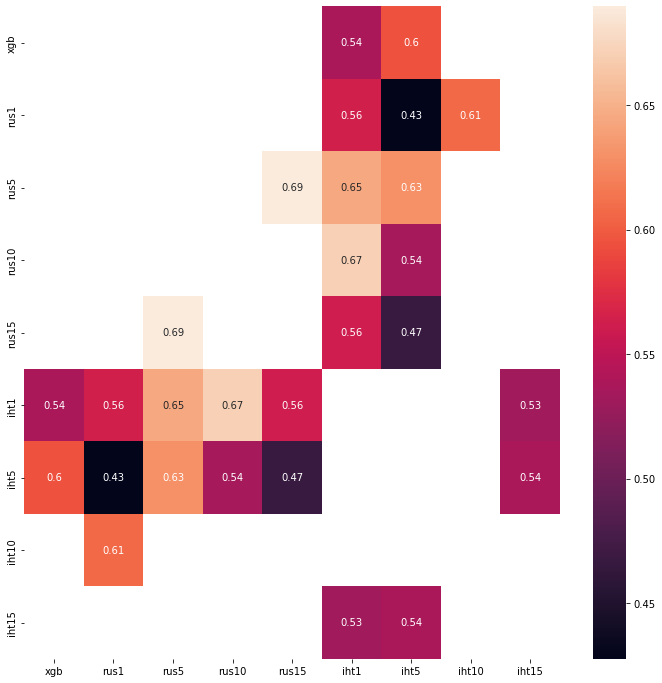

In [128]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(shap_importance.corr(method = 'spearman')[(shap_importance.corr(method = 'spearman') <= 0.692)],
            annot=True);

### 6.1.3  SHAP feature importance visualisation

In [129]:
#select top 10 features for original xgb
shap_top10 = shap_importance.sort_values(['xgb'], ascending=[False])
shap_top10 = shap_top10.head(10)
shap_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
8,DEBTINC,0.038,0.145,0.095,0.066,0.035,0.084,0.051,0.051,0.036
5,DELINQ,0.018,0.067,0.035,0.021,0.014,0.087,0.047,0.025,0.020
6,CLAGE,0.011,0.045,0.024,0.021,0.013,0.022,0.012,0.013,0.012
4,DEROG,0.007,0.014,0.010,0.008,0.007,0.033,0.013,0.014,0.011
0,LOAN,0.006,0.040,0.014,0.013,0.007,0.053,0.012,0.012,0.008
3,YOJ,0.006,0.034,0.019,0.009,0.003,0.027,0.012,0.008,0.005
1,MORTDUE,0.005,0.024,0.017,0.011,0.005,0.055,0.017,0.015,0.007
2,VALUE,0.005,0.025,0.015,0.012,0.004,0.057,0.013,0.014,0.005
7,NINQ,0.005,0.010,0.011,0.007,0.002,0.051,0.020,0.012,0.004
10,JOB,0.004,0.021,0.009,0.007,0.003,0.009,0.006,0.007,0.005


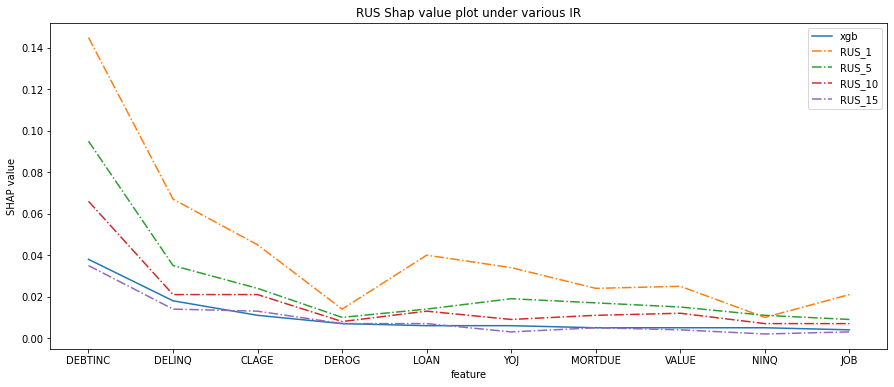

In [130]:
#1.aggeragate by approaches
#rus under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
rus_1 =shap_top10['rus1'].tolist()
rus_5 =shap_top10['rus5'].tolist()
rus_10 =shap_top10['rus10'].tolist()
rus_15 =shap_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('RUS Shap value plot under various IR')
plt.show()

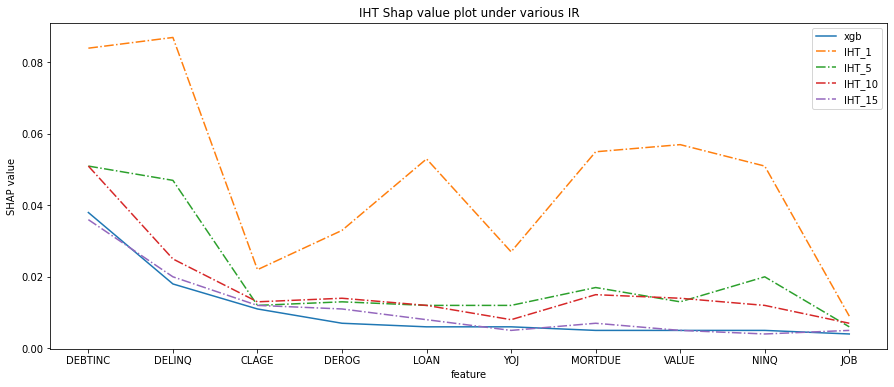

In [131]:
#iht under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
iht_1 =shap_top10['iht1'].tolist()
iht_5 =shap_top10['iht5'].tolist()
iht_10 =shap_top10['iht10'].tolist()
iht_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('IHT Shap value plot under various IR')
plt.show()

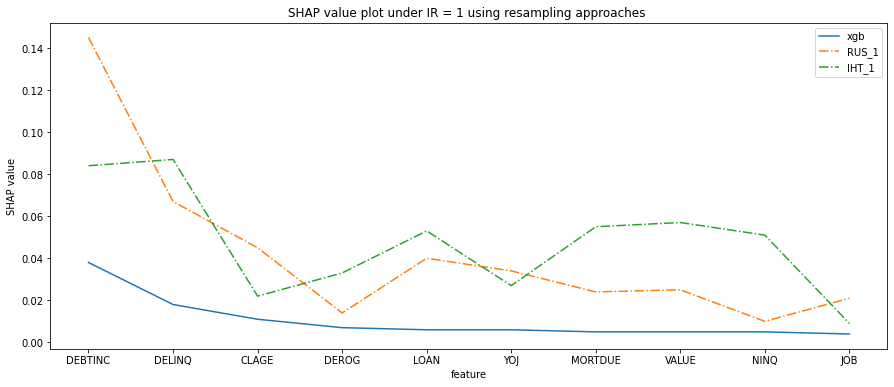

In [132]:
#aggeragate by ratio
#IR=1 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_1 =shap_top10['rus1'].tolist()
IHT_1 =shap_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 1 using resampling approaches ')
plt.show()

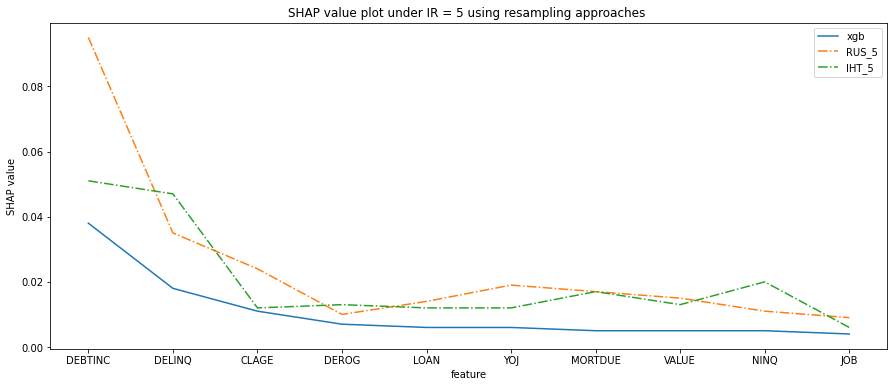

In [133]:
#IR=5 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_5 =shap_top10['rus5'].tolist()
IHT_5 =shap_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 5 using resampling approaches ')
plt.show()

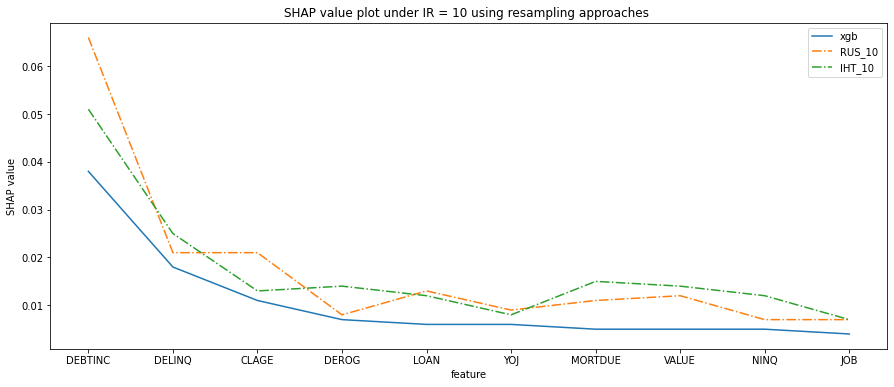

In [134]:
#IR=10 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_10 =shap_top10['rus10'].tolist()
IHT_10 =shap_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 10 using resampling approaches ')
plt.show()

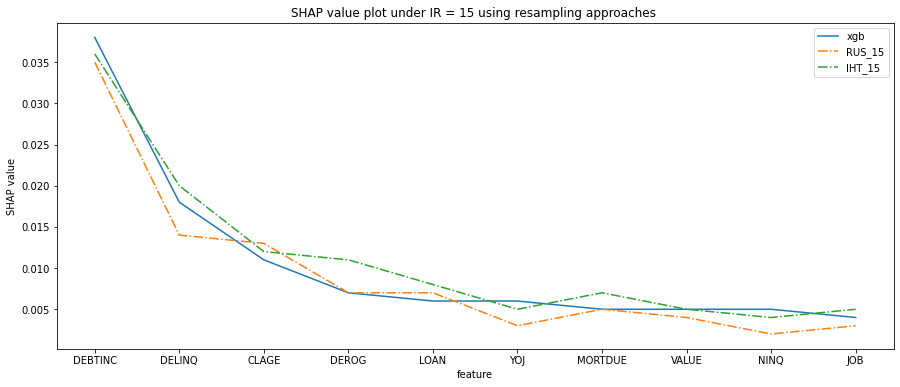

In [135]:
#IR=15 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_15 =shap_top10['rus15'].tolist()
IHT_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 15 using resampling approaches ')
plt.show()

## 6.2 PFI

### 6.2.1 Calculate PFI

In [136]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
pfi_xgb = permutation_importance(xgb_tune, X_train_final, y_train, scoring='roc_auc', n_repeats=5, random_state=1)
pfi_importance = pd.concat([pd.DataFrame(X_train_final.columns),pd.DataFrame(pfi_xgb.importances_mean.round(3))],axis = 1)
pfi_importance = pfi_importance.set_axis(['feature','xgb'], axis='columns')
pfi_importance.head()

,feature,xgb
0,LOAN,0.008
1,MORTDUE,0.007
2,VALUE,0.007
3,YOJ,0.008
4,DEROG,0.002


In [137]:
def pfi_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [138]:
pfi_list = pfi_generator(RE_Xlist, RE_ylist,xgb_tune)

[0]	validation_0-auc:0.64009
[1]	validation_0-auc:0.74397
[2]	validation_0-auc:0.70748
[3]	validation_0-auc:0.71456
[4]	validation_0-auc:0.72308
[5]	validation_0-auc:0.79952
[6]	validation_0-auc:0.83417
[7]	validation_0-auc:0.83475
[8]	validation_0-auc:0.82105
[9]	validation_0-auc:0.82810
[10]	validation_0-auc:0.84115
[11]	validation_0-auc:0.84510
[12]	validation_0-auc:0.83480
[13]	validation_0-auc:0.84049
[14]	validation_0-auc:0.84676
[15]	validation_0-auc:0.85173
[16]	validation_0-auc:0.85219
[17]	validation_0-auc:0.86140
[18]	validation_0-auc:0.87107
[19]	validation_0-auc:0.87219
[20]	validation_0-auc:0.87508
[21]	validation_0-auc:0.87401
[22]	validation_0-auc:0.87183
[23]	validation_0-auc:0.87488
[24]	validation_0-auc:0.87762
[25]	validation_0-auc:0.88023
[26]	validation_0-auc:0.88325
[27]	validation_0-auc:0.87919
[28]	validation_0-auc:0.88140
[29]	validation_0-auc:0.88379
[30]	validation_0-auc:0.88437
[31]	validation_0-auc:0.88305
[32]	validation_0-auc:0.88247
[33]	validation_0-au

[75]	validation_0-auc:0.91787
[76]	validation_0-auc:0.91830
[77]	validation_0-auc:0.91754
[78]	validation_0-auc:0.91840
[79]	validation_0-auc:0.91952
[80]	validation_0-auc:0.92046
[81]	validation_0-auc:0.91962
[82]	validation_0-auc:0.91934
[83]	validation_0-auc:0.91858
[84]	validation_0-auc:0.91939
[85]	validation_0-auc:0.92125
[86]	validation_0-auc:0.92150
[87]	validation_0-auc:0.92163
[88]	validation_0-auc:0.92094
[89]	validation_0-auc:0.91998
[90]	validation_0-auc:0.91927
[91]	validation_0-auc:0.91881
[92]	validation_0-auc:0.91726
[93]	validation_0-auc:0.91762
[94]	validation_0-auc:0.91764
[95]	validation_0-auc:0.91731
[96]	validation_0-auc:0.91815
[97]	validation_0-auc:0.91812
[98]	validation_0-auc:0.91764
[99]	validation_0-auc:0.91767
[0]	validation_0-auc:0.70054
[1]	validation_0-auc:0.76809
[2]	validation_0-auc:0.74771
[3]	validation_0-auc:0.74845
[4]	validation_0-auc:0.84891
[5]	validation_0-auc:0.87268
[6]	validation_0-auc:0.87828
[7]	validation_0-auc:0.89093
[8]	validation_0-a

[50]	validation_0-auc:0.78861
[51]	validation_0-auc:0.78676
[52]	validation_0-auc:0.78851
[53]	validation_0-auc:0.78952
[54]	validation_0-auc:0.79018
[55]	validation_0-auc:0.78909
[56]	validation_0-auc:0.78825
[57]	validation_0-auc:0.78790
[58]	validation_0-auc:0.78714
[59]	validation_0-auc:0.78881
[60]	validation_0-auc:0.78924
[61]	validation_0-auc:0.78909
[62]	validation_0-auc:0.78785
[63]	validation_0-auc:0.78688
[64]	validation_0-auc:0.78531
[65]	validation_0-auc:0.78749
[66]	validation_0-auc:0.78671
[67]	validation_0-auc:0.78886
[68]	validation_0-auc:0.78907
[69]	validation_0-auc:0.78897
[70]	validation_0-auc:0.79087
[71]	validation_0-auc:0.78975
[72]	validation_0-auc:0.78833
[73]	validation_0-auc:0.78874
[74]	validation_0-auc:0.78990
[75]	validation_0-auc:0.79069
[76]	validation_0-auc:0.79064
[77]	validation_0-auc:0.79077
[78]	validation_0-auc:0.79102
[79]	validation_0-auc:0.79016
[80]	validation_0-auc:0.78983
[81]	validation_0-auc:0.79087
[82]	validation_0-auc:0.79165
[83]	valid

In [157]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
pfi_importance['rus1'] = pfi_list[0]
pfi_importance['rus5'] = pfi_list[1]
pfi_importance['rus10'] = pfi_list[2]
pfi_importance['rus15'] = pfi_list[3]
pfi_importance['iht1'] = pfi_list[4]
pfi_importance['iht5'] = pfi_list[5]
pfi_importance['iht10'] = pfi_list[6]
pfi_importance['iht15'] = pfi_list[7]

pfi_importance

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LOAN,0.008,0.010,0.005,0.008,0.012,0.011,0.004,0.005,0.011
1,MORTDUE,0.007,0.006,0.011,0.009,0.015,0.009,0.012,0.007,0.007
2,VALUE,0.007,0.007,0.007,0.007,0.007,0.011,0.005,0.007,0.004
3,YOJ,0.008,0.012,0.010,0.007,0.009,0.004,0.008,0.006,0.007
4,DEROG,0.002,0.001,0.001,0.002,0.002,0.004,0.009,0.006,0.002
5,DELINQ,0.009,0.021,0.010,0.010,0.021,0.035,0.030,0.015,0.015
6,CLAGE,0.015,0.013,0.009,0.021,0.033,0.002,0.008,0.012,0.018
7,NINQ,0.002,0.001,0.002,0.003,0.002,0.013,0.012,0.005,0.002
8,DEBTINC,0.050,0.084,0.101,0.085,0.071,0.021,0.045,0.058,0.040
9,REASON,0.001,0.001,0.000,0.001,0.002,0.000,0.001,0.001,0.001


In [156]:
pfi_importance.to_csv('/kaggle/working/pfi_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.2.2 PFI rank correlation

In [142]:
rank_pfi = pfi_importance.corr(method = 'spearman').round(3)
print(rank_pfi)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.979  0.823  0.950  0.952  0.447  0.462  0.794  0.984
rus1   0.979  1.000  0.820  0.910  0.926  0.467  0.433  0.786  0.947
rus5   0.823  0.820  1.000  0.876  0.871  0.520  0.651  0.813  0.821
rus10  0.950  0.910  0.876  1.000  0.989  0.486  0.547  0.836  0.972
rus15  0.952  0.926  0.871  0.989  1.000  0.406  0.488  0.814  0.975
iht1   0.447  0.467  0.520  0.486  0.406  1.000  0.747  0.531  0.433
iht5   0.462  0.433  0.651  0.547  0.488  0.747  1.000  0.727  0.476
iht10  0.794  0.786  0.813  0.836  0.814  0.531  0.727  1.000  0.770
iht15  0.984  0.947  0.821  0.972  0.975  0.433  0.476  0.770  1.000


In [158]:
rank_pfi.to_csv('/kaggle/working/rank_pfi.csv', index = True, encoding = 'utf-8-sig') 

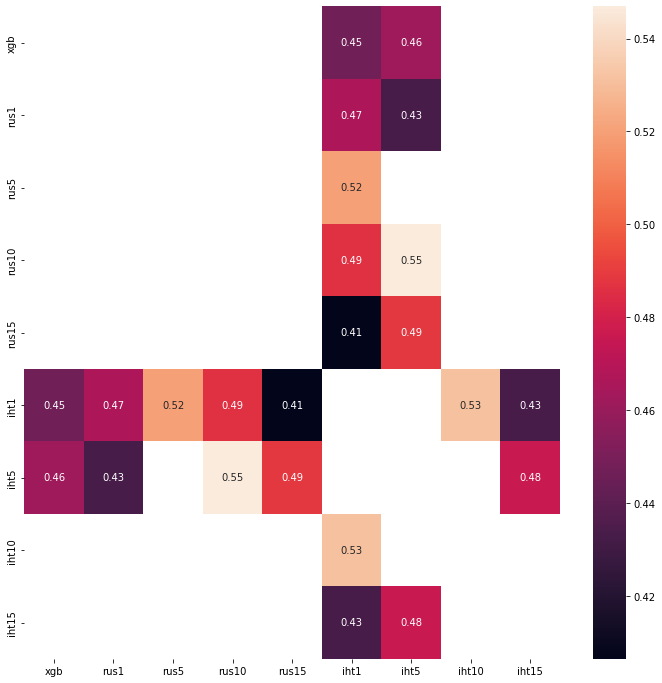

In [145]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(pfi_importance.corr(method = 'spearman')[(pfi_importance.corr(method = 'spearman') <= 0.695)],
            annot=True);


### 6.2.3 PFI feature importance visualisation

In [146]:
#select top 10 features for original xgb
pfi_top10 = pfi_importance.sort_values(['xgb'], ascending=[False])
pfi_top10 = pfi_top10.head(10)
pfi_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
8,DEBTINC,0.050,0.084,0.101,0.085,0.071,0.021,0.045,0.058,0.040
6,CLAGE,0.015,0.013,0.009,0.021,0.033,0.002,0.008,0.012,0.018
5,DELINQ,0.009,0.021,0.010,0.010,0.021,0.035,0.030,0.015,0.015
0,LOAN,0.008,0.010,0.005,0.008,0.012,0.011,0.004,0.005,0.011
3,YOJ,0.008,0.012,0.010,0.007,0.009,0.004,0.008,0.006,0.007
1,MORTDUE,0.007,0.006,0.011,0.009,0.015,0.009,0.012,0.007,0.007
2,VALUE,0.007,0.007,0.007,0.007,0.007,0.011,0.005,0.007,0.004
10,JOB,0.005,0.005,0.002,0.005,0.005,0.000,0.003,0.005,0.004
4,DEROG,0.002,0.001,0.001,0.002,0.002,0.004,0.009,0.006,0.002
7,NINQ,0.002,0.001,0.002,0.003,0.002,0.013,0.012,0.005,0.002


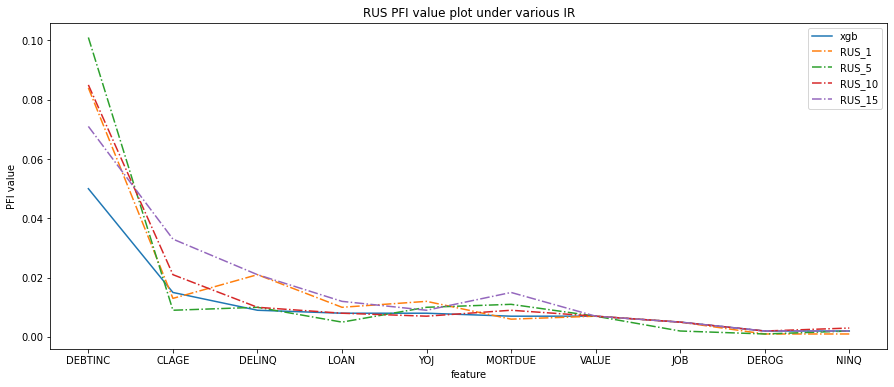

In [147]:
#1.aggeragate by approaches
#rus under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
rus_1 =pfi_top10['rus1'].tolist()
rus_5 =pfi_top10['rus5'].tolist()
rus_10 =pfi_top10['rus10'].tolist()
rus_15 =pfi_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('RUS PFI value plot under various IR')
plt.show()

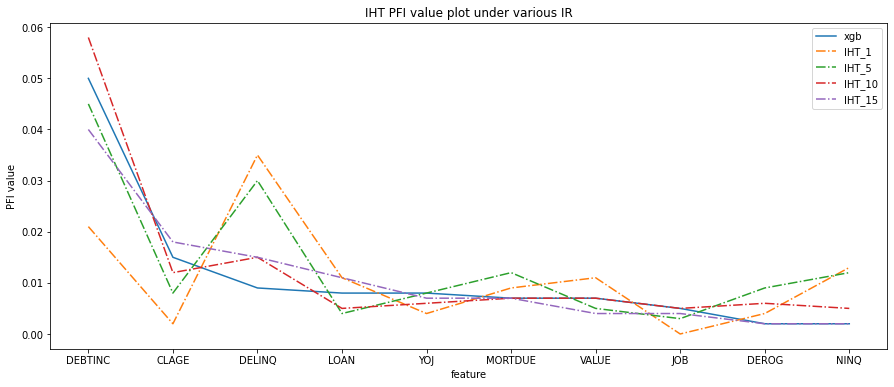

In [148]:
#iht under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
iht_1 =pfi_top10['iht1'].tolist()
iht_5 =pfi_top10['iht5'].tolist()
iht_10 =pfi_top10['iht10'].tolist()
iht_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('IHT PFI value plot under various IR')
plt.show()


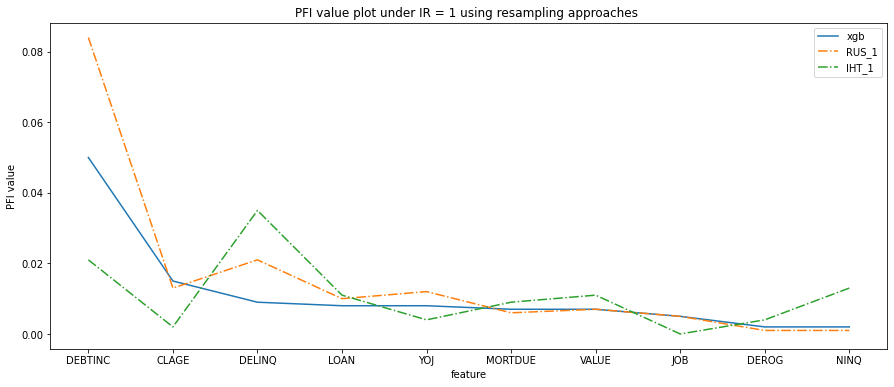

In [149]:
#aggeragate by ratio
#IR=1 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_1 =pfi_top10['rus1'].tolist()
IHT_1 =pfi_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 1 using resampling approaches ')
plt.show()


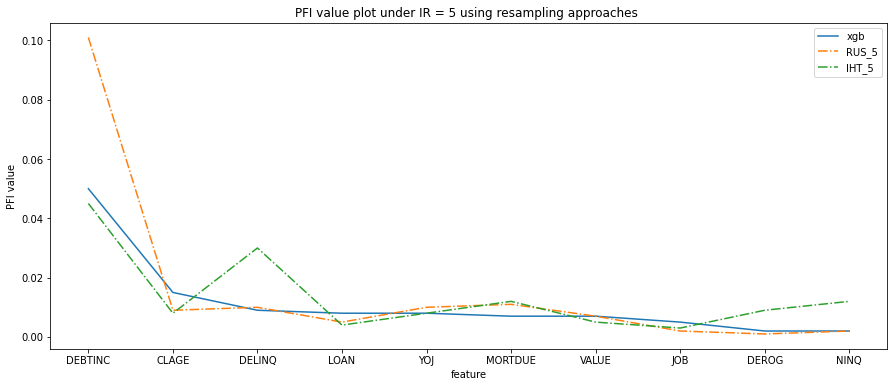

In [150]:
#IR=5 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_5 =pfi_top10['rus5'].tolist()
IHT_5 =pfi_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 5 using resampling approaches ')
plt.show()


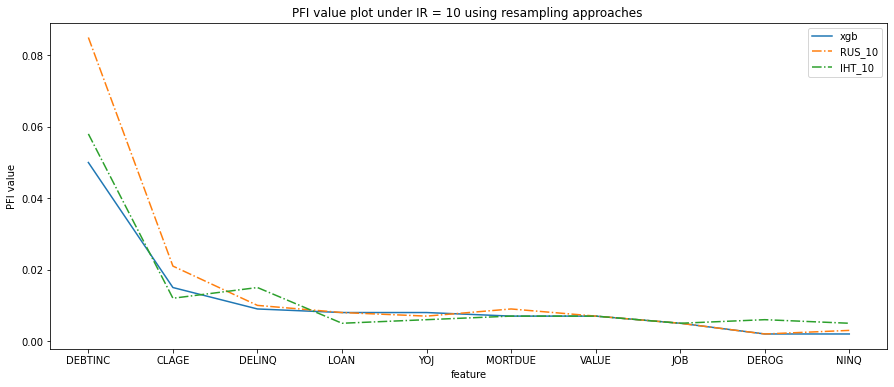

In [151]:
#IR=10 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_10 =pfi_top10['rus10'].tolist()
IHT_10 =pfi_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 10 using resampling approaches ')
plt.show()


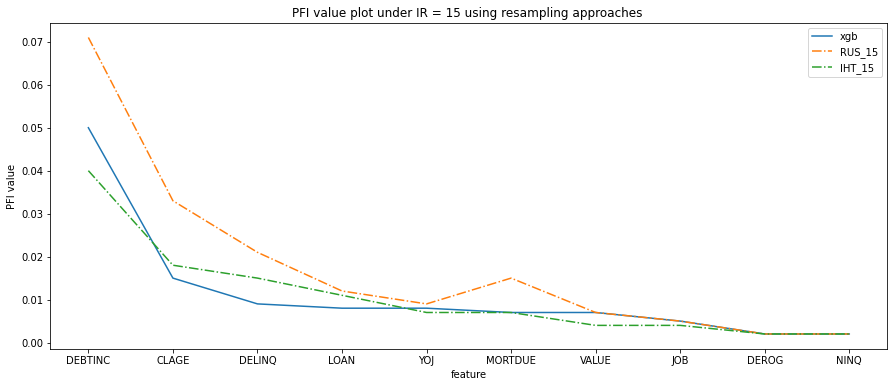

In [152]:
#IR=15 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_15 =pfi_top10['rus15'].tolist()
IHT_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 15 using resampling approaches ')
plt.show()
